In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchmetrics.classification import BinaryF1Score
from hn_utils import HNDataset, mean_and_std, loss_plot, acc_plot
from train import fit
from models import BaselineExpressionModelV0, HnModelV1

In [2]:
train_path = 'data/Master Folder/train'
test_path =  'data/Master Folder/test'
valid_path = 'data/Master Folder/valid'

In [66]:
transforms = T.Compose([
    T.Resize(157),
    T.ToTensor(),
])

In [4]:
train_dt = HNDataset(root_dir=train_path, transforms=transforms)
train_ds = DataLoader(train_dt, batch_size=64, shuffle = True)

In [5]:
test_dt = HNDataset(root_dir=test_path, transforms=transforms)
test_ds = DataLoader(test_dt, batch_size=64, shuffle = False)

In [6]:
val_dt = HNDataset(root_dir= valid_path, transforms=transforms)
val_ds = DataLoader(val_dt, batch_size=64, shuffle = False)

In [7]:
mean, std = mean_and_std(train_dt)

In [8]:
mean, std

(tensor([0.5001, 0.4557, 0.4074]), tensor([0.2769, 0.2659, 0.2692]))

In [9]:
train_image_batch, train_image_label = next(iter(train_ds))

In [10]:
len(train_image_batch), train_image_batch.shape

(64, torch.Size([64, 3, 157, 157]))

In [11]:
train_image_batch[0], train_image_label[0]

(tensor([[[0.6588, 0.6863, 0.7059,  ..., 0.8941, 0.8941, 0.8902],
          [0.6510, 0.6784, 0.6980,  ..., 0.8941, 0.8980, 0.8980],
          [0.6392, 0.6706, 0.6902,  ..., 0.8941, 0.8941, 0.8941],
          ...,
          [0.4863, 0.4980, 0.5137,  ..., 0.7294, 0.7608, 0.8039],
          [0.4863, 0.4784, 0.4784,  ..., 0.7176, 0.7725, 0.7843],
          [0.5176, 0.5059, 0.4863,  ..., 0.7098, 0.7686, 0.7608]],
 
         [[0.6667, 0.6941, 0.7137,  ..., 0.9098, 0.9098, 0.9059],
          [0.6588, 0.6863, 0.7059,  ..., 0.9098, 0.9137, 0.9137],
          [0.6471, 0.6784, 0.6980,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.4588, 0.4627, 0.4784,  ..., 0.6902, 0.7255, 0.7686],
          [0.4549, 0.4431, 0.4431,  ..., 0.6745, 0.7333, 0.7451],
          [0.4863, 0.4706, 0.4510,  ..., 0.6667, 0.7255, 0.7176]],
 
         [[0.6235, 0.6471, 0.6627,  ..., 0.9216, 0.9216, 0.9176],
          [0.6157, 0.6392, 0.6549,  ..., 0.9216, 0.9255, 0.9255],
          [0.6039, 0.6275, 0.6471,  ...,

In [12]:
class_names = list(train_dt.class_to_index.keys())

In [13]:
class_names

['happy', 'not_happy']

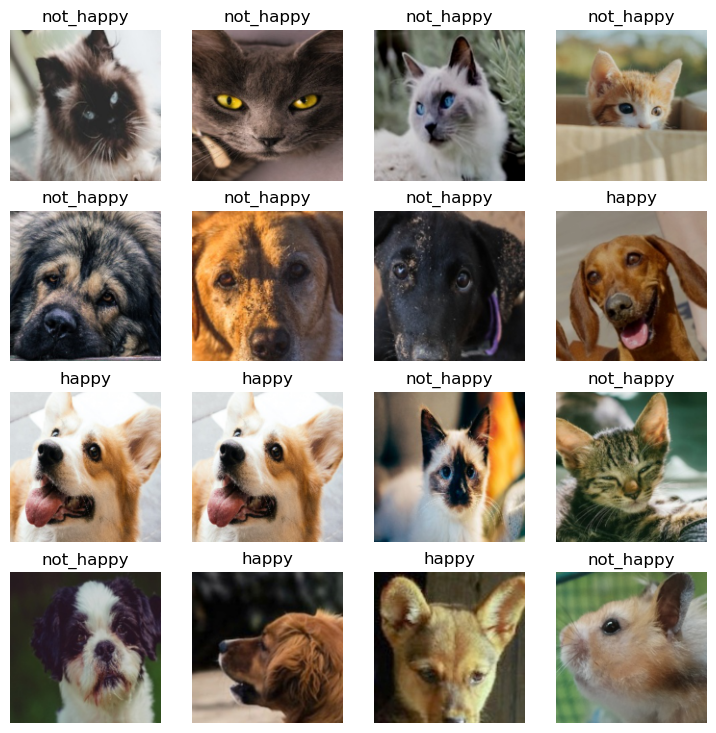

In [14]:
fig = plt.figure(figsize = (9,9))

rows, cols = 4,4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_image_batch), size = [1]).item()
    img_data, label = train_image_batch[random_idx], train_image_label[random_idx]
    img = np.transpose(img_data.squeeze(), (1,2,0))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(class_names[label.argmax()])
    plt.axis('Off')

In [95]:
model_0 = BaselineExpressionModelV0(num_classes = len(class_names), mean=mean, std=std)

In [16]:
numel_list = [p.numel() for p in model_0.parameters()]
print(f'No of Parameters: {sum(numel_list)}')

No of Parameters: 60815426


In [17]:
optim = torch.optim.SGD(params = model_0.parameters(), lr = 1e-3, weight_decay = 0.3)
loss_fn = nn.BCEWithLogitsLoss()
acc_fn = BinaryF1Score()

In [18]:
train_image_batch[30].unsqueeze(dim = 0).shape

torch.Size([1, 3, 157, 157])

In [19]:
pred = model_0(train_image_batch[30].unsqueeze(dim = 0))
pred

tensor([[ 0.2675, -0.2240]], grad_fn=<AddmmBackward0>)

In [20]:
train_image_label[30], pred.squeeze()

(tensor([0., 1.]), tensor([ 0.2675, -0.2240], grad_fn=<SqueezeBackward0>))

In [21]:
loss = loss_fn(pred.squeeze(), train_image_label[30])
loss

tensor(0.8236, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [22]:
prediction = torch.argmax(torch.sigmoid(pred))
target = torch.argmax(train_image_label[30])
print(f'Prediction: {prediction}')
print(f'Target: {target}')
class_names[prediction], class_names[target]

Prediction: 0
Target: 1


('happy', 'not_happy')

In [23]:
acc = acc_fn(pred.squeeze(), train_image_label[30])
acc.item() * 100

0.0

In [96]:
history = fit(net = model_0, epochs = 30, trainloader=train_ds, testloader=test_ds, optimizer=optim, criterion=loss_fn, acc_fn=acc_fn, display_range=10)

Epoch: 10
Train Loss: 0.6888711825013161, Training Accuracy : 0.5863931365311146
Test Loss: 0.6856206059455872, Test Accuracy : 0.5555555820465088
-------------------------------------------------------
-------------------------------------------------------
Epoch: 20
Train Loss: 0.6904841959476471, Training Accuracy : 0.5762656088918447
Test Loss: 0.6853463053703308, Test Accuracy : 0.6279069781303406
-------------------------------------------------------
-------------------------------------------------------
Finished Training


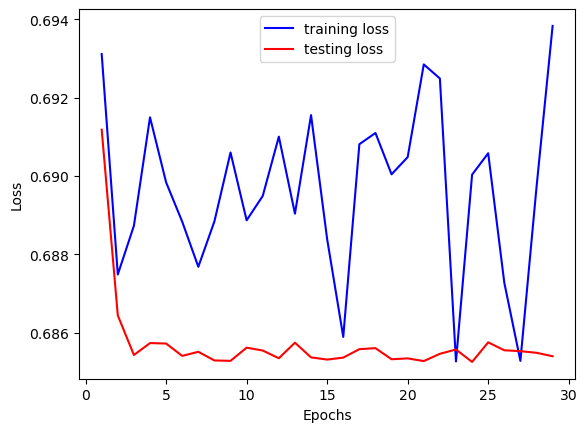

In [97]:
loss_plot(history=history)

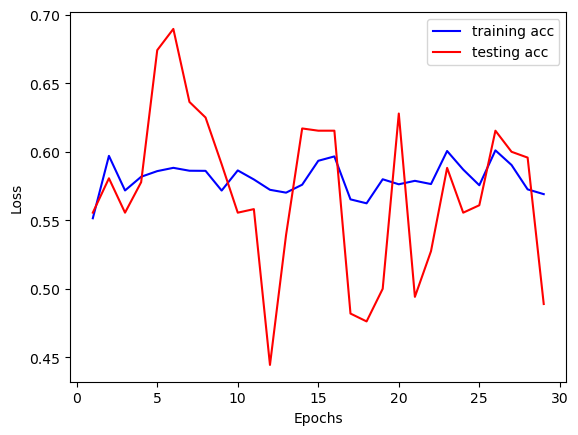

In [98]:
acc_plot(history=history)

In [27]:
# model_1 = HnModelV1(num_classes = len(class_names), mean=mean, std=std)

In [28]:
# history_1 = fit(net = model_1, epochs = 50, trainloader=train_ds, testloader=test_ds, optimizer=optim, criterion=loss_fn, acc_fn=acc_fn)

In [29]:
# loss_plot(history=history_1)

In [30]:
# acc_plot(history=history_1)

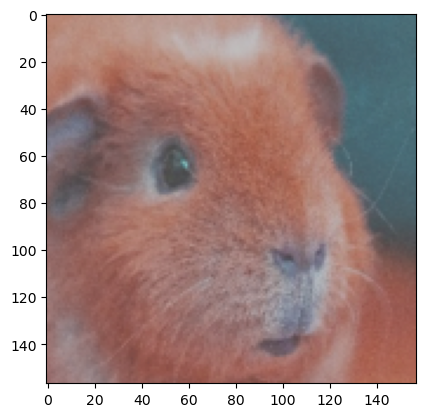

In [83]:
happy_transforms = T.Compose([
    T.RandomVerticalFlip(0.6),
    T.ColorJitter(0.2, 0.7, 0.3, 0.1),
    T.ToTensor()
])
thirth_img =  T.ToPILImage()(train_image_batch[40])
transformed_image = happy_transforms(thirth_img)
plt.imshow(transformed_image.permute(1,2,0))

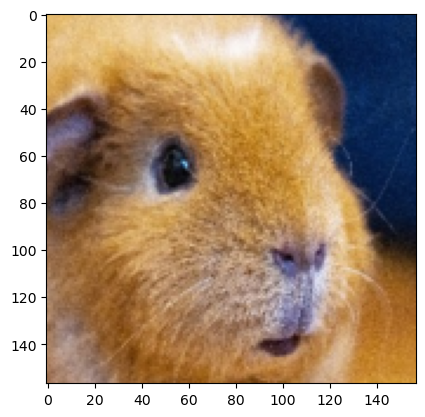

In [79]:
plt.imshow(train_image_batch[40].permute(1,2,0))

In [80]:
augumented_train_dt = HNDataset(train_path, transforms=transforms, happy_transforms=happy_transforms)
augumented_train_ds = DataLoader(augumented_train_dt, batch_size=64, shuffle=True)

In [81]:
train_aug_image_batch, train_aug_image_label = next(iter(augumented_train_ds))

In [73]:
train_aug_image_batch[20].shape

torch.Size([3, 157, 157])

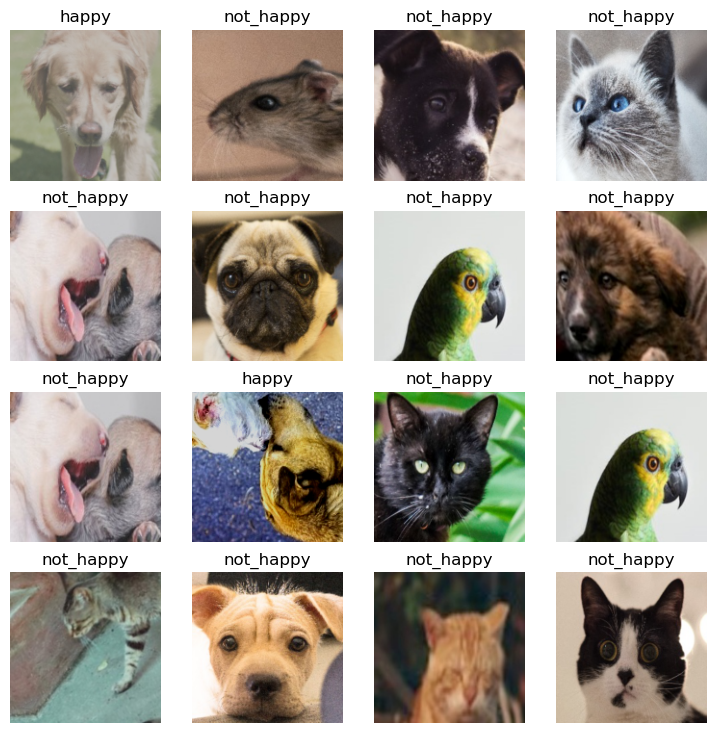

In [86]:
fig = plt.figure(figsize = (9,9))

rows, cols = 4,4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_image_batch), size = [1]).item()
    img_data, label = train_aug_image_batch[random_idx], train_aug_image_label[random_idx]
    img = np.transpose(img_data.squeeze(), (1,2,0))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(class_names[label.argmax()])
    plt.axis('Off')

In [92]:
history_1 = fit(net = model_0, epochs = 30, trainloader=augumented_train_ds, testloader=test_ds, optimizer=optim, criterion=loss_fn, acc_fn=acc_fn, display_range=5)

Epoch: 5
Train Loss: 0.7276335954666138, Training Accuracy : 0.4617376159876585
Test Loss: 0.7010558247566223, Test Accuracy : 0.44186046719551086
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10
Train Loss: 0.725702416151762, Training Accuracy : 0.4705379568040371
Test Loss: 0.7011882662773132, Test Accuracy : 0.5306122303009033
-------------------------------------------------------
-------------------------------------------------------
Epoch: 15
Train Loss: 0.7299893014132977, Training Accuracy : 0.44538450241088867
Test Loss: 0.7012931108474731, Test Accuracy : 0.41304346919059753
-------------------------------------------------------
-------------------------------------------------------
Epoch: 20
Train Loss: 0.7311823628842831, Training Accuracy : 0.461607214063406
Test Loss: 0.7010830044746399, Test Accuracy : 0.4444444477558136
-------------------------------------------------------
--------------------

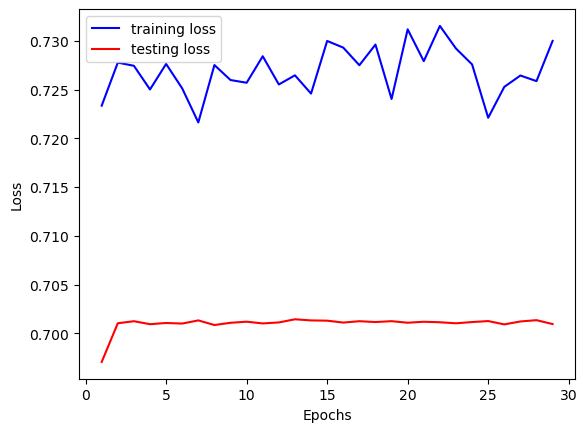

In [93]:
loss_plot(history=history_1)

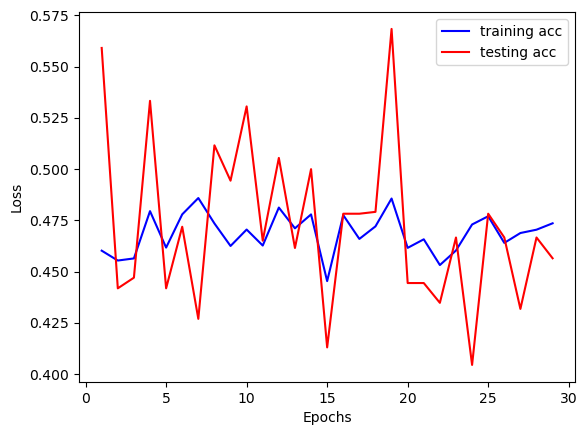

In [94]:
acc_plot(history=history_1)